In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
# define ODEs
def VanDerPol(y, t, epsilon):
    x, y = y
    #dxdt = y
    #dydt = epsilon * (1 - x**2) * y - x
    dxdt = y - (x**3)/3 + x
    dydt = -epsilon * x
    return [dxdt, dydt]

In [3]:
y0 = [2, 0]
t = np.linspace(0, 100, 200)  
epsilon = 0.1
#epsilon = 2

In [4]:
# solve ODEs
x_real, y_real = odeint(VanDerPol, y0,  t, args=(epsilon,)).T
# tranform to tensor
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float32)
x_real_tensor = torch.tensor(x_real.reshape(-1, 1), dtype=torch.float32)
y_real_tensor = torch.tensor(y_real.reshape(-1, 1), dtype=torch.float32)

In [5]:
def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

In [6]:
class PINN(nn.Module):
    def __init__(self, num_nrn = 100):
        super(PINN, self).__init__()
        
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)
        # Batch normalization layers
#        self.bn1 = nn.BatchNorm1d(num_nrn)
#        self.bn2 = nn.BatchNorm1d(num_nrn)

    def forward(self, t):
        t = input_transform(t)  
        x = torch.tanh(self.fc1(t))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

 ## We can write a line of code to pick some (like 10) random points over the slow (critical) manifold
 ## $y_{pred} + \frac{1}{3}x_{pred}^3 - x_{pred}=0$ for $x>1$ when $y<\frac{2}{3}$ and $x<-1$ when $y>\frac{-2}{3}$


In [7]:
def loss_func(model, t_tensor, x_real, y_real, x0, y0, epsilon, random_points=10):
    
    t_tensor.requires_grad = True
    pred = model(t_tensor)
    x_pred, y_pred = pred[:, 0].unsqueeze(1), pred[:, 1].unsqueeze(1)

    dx_dt = torch.autograd.grad(x_pred.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred.sum(), t_tensor, retain_graph=True, create_graph=True)[0]

    #residual1 = dx_dt - y_pred
    #residual2 = dy_dt - (epsilon *(1 - x_pred**2) * y_pred - x_pred)
    residual1 = dx_dt - y_pred + (1/3) * x_pred**3 - x_pred
    residual2 = dy_dt + epsilon * x_pred
    
    init_loss = torch.square(x_pred[0] - x0) + torch.square(y_pred[0] - y0)
    physics_loss = torch.mean(residual1**2 + residual2**2)
    #random_indices = torch.randint(0, x_real.shape[0], (random_points,))
    # Pick 10 random points within the first 10 seconds (0 to 10)
    random_indices = np.random.choice(np.where(t <= 70)[0], 10, replace=False)
    data_loss = torch.mean((x_pred[random_indices] - x_real[random_indices])**2 + 
                           (y_pred[random_indices] - y_real[random_indices])**2)
    
    #adjust weights
    total_loss =  10 * physics_loss + 0.1 * init_loss + data_loss
    #total_loss = data_loss
    return total_loss

Epoch 0, Loss: 4.064027786254883
Epoch 1000, Loss: 2.923187732696533
Epoch 2000, Loss: 2.3311057090759277
Epoch 3000, Loss: 3.068598508834839
Epoch 4000, Loss: 1.6109505891799927
Epoch 5000, Loss: 1.876102089881897
Epoch 6000, Loss: 1.9524887800216675
Epoch 7000, Loss: 1.9683895111083984
Epoch 8000, Loss: 2.260209083557129
Epoch 9000, Loss: 0.934816300868988
Epoch 10000, Loss: 1.103348731994629
Epoch 11000, Loss: 2.393076181411743
Epoch 12000, Loss: 0.8963069915771484
Epoch 13000, Loss: 0.2934802174568176
Epoch 14000, Loss: 0.23407280445098877
Epoch 15000, Loss: 0.5649614334106445
Epoch 16000, Loss: 0.14434193074703217
Epoch 17000, Loss: 0.6942617893218994
Epoch 18000, Loss: 0.29553744196891785
Epoch 19000, Loss: 0.14543886482715607
Epoch 20000, Loss: 0.4737611413002014
Epoch 21000, Loss: 0.4964474141597748
Epoch 22000, Loss: 0.2957324981689453
Epoch 23000, Loss: 0.11919216066598892
Epoch 24000, Loss: 0.4399458169937134
Epoch 25000, Loss: 0.32012939453125
Epoch 26000, Loss: 0.121993750

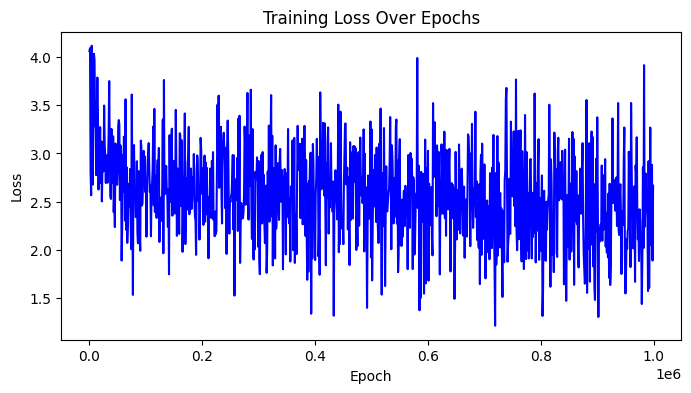

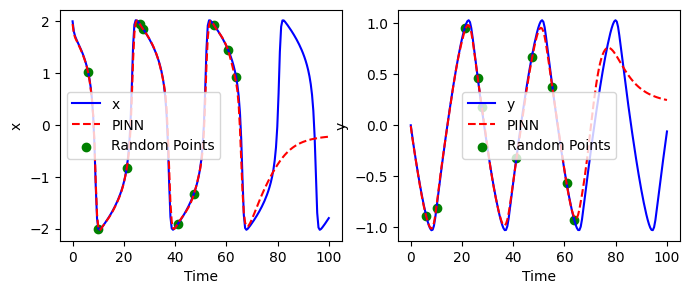

In [8]:
if __name__=='__main__':

    model = PINN()
    # L2 regularization strength (lambda value)
    lambd = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=lambd)
    loss_values = []
    epoch_num = 1000000
    for epoch in range(epoch_num):

        loss = loss_func(model, t_tensor, x_real_tensor, y_real_tensor, y0[0], y0[1], epsilon, random_points=10)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
        loss_values.append(loss.item())
        
    plt.figure(figsize=(8, 4))
    plt.plot(range(0, epoch_num, 1000), loss_values[:epoch_num//1000], 'b-')  
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()



    # model evaluation
    model.eval()
    with torch.no_grad():
        x_pred, y_pred = model(t_tensor).numpy().T
        
    #random_indices = torch.randint(0, x_real.shape[0], (10,))
    # Pick 10 random points within the first 10 seconds (0 to 10)
    random_indices = np.random.choice(np.where(t <= 70)[0], 10, replace=False)
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(t, x_real, 'b-', label='x')
    plt.plot(t, x_pred, 'r--', label='PINN')
    plt.scatter(t[random_indices], x_real[random_indices], color='green', label='Random Points')  # Add randomly selected points
    plt.xlabel('Time')
    plt.ylabel('x')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(t, y_real, 'b-', label='y')
    plt.plot(t, y_pred, 'r--', label='PINN')
    plt.scatter(t[random_indices], y_real[random_indices], color='green', label='Random Points')  # Add randomly selected points
    plt.xlabel('Time')
    plt.ylabel('y')
    plt.legend()
    plt.show()

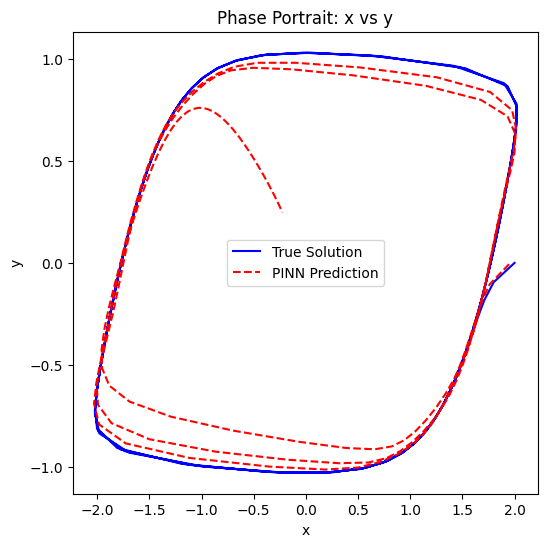

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(x_real, y_real, 'b-', label='True Solution')
plt.plot(x_pred, y_pred, 'r--', label='PINN Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Phase Portrait: x vs y')
plt.legend()
plt.show()